In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path

from data.preprocess import load_processed_data
from models.mlp_classifier import MLPClassifier, MLPTrainer
from models.model_utils import evaluate_binary_classifier
from models.threshold_optimizer import optimize_threshold_for_profit, plot_threshold_optimization

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
print('✅ Imports complete')

PyTorch version: 2.9.1
CUDA available: False
✅ Imports complete


## 1. Load Data

In [9]:
# Load processed data
train_df, val_df, test_df = load_processed_data('../data/processed', verbose=True)

# Store original for profit calculations
val_df_original = val_df.copy()

# Extract features and target
X_train = train_df.drop('default', axis=1).copy()
y_train = train_df['default'].values

X_val = val_df.drop('default', axis=1).copy()
y_val = val_df['default'].values

X_test = test_df.drop('default', axis=1).copy()
y_test = test_df['default'].values

# Preprocess features (same as in 03_supervised_baselines.ipynb)
from sklearn.preprocessing import LabelEncoder

# Convert date columns to numeric
date_cols = [col for col in X_train.columns if 'date' in col.lower() or col in ['issue_d', 'earliest_cr_line', 'sec_app_earliest_cr_line']]
for col in date_cols:
    if col in X_train.columns and X_train[col].dtype == 'object':
        try:
            X_train[col] = pd.to_datetime(X_train[col], errors='coerce').astype('int64') // 10**9
            X_val[col] = pd.to_datetime(X_val[col], errors='coerce').astype('int64') // 10**9
            X_test[col] = pd.to_datetime(X_test[col], errors='coerce').astype('int64') // 10**9
        except:
            pass

# Identify categorical columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove high-cardinality ID columns
id_cols = [col for col in cat_cols if 'id' in col.lower() or col in ['url', 'desc', 'emp_title', 'title']]
if id_cols:
    X_train = X_train.drop(columns=id_cols)
    X_val = X_val.drop(columns=id_cols)
    X_test = X_test.drop(columns=id_cols)
    cat_cols = [col for col in cat_cols if col not in id_cols]

# Encode categorical features
if len(cat_cols) > 0:
    for col in cat_cols:
        le = LabelEncoder()
        X_train.loc[:, col] = le.fit_transform(X_train[col].astype(str))
        
        # Handle unseen values
        train_classes = set(le.classes_)
        val_encoded = [le.transform([val])[0] if val in train_classes else -1 for val in X_val[col].astype(str)]
        test_encoded = [le.transform([val])[0] if val in train_classes else -1 for val in X_test[col].astype(str)]
        
        X_val.loc[:, col] = val_encoded
        X_test.loc[:, col] = test_encoded

# Handle remaining non-numeric columns
remaining_non_numeric = X_train.select_dtypes(exclude=['number']).columns.tolist()
if remaining_non_numeric:
    for col in remaining_non_numeric:
        le = LabelEncoder()
        X_train.loc[:, col] = le.fit_transform(X_train[col].astype(str))
        train_classes = set(le.classes_)
        X_val.loc[:, col] = [le.transform([val])[0] if val in train_classes else -1 for val in X_val[col].astype(str)]
        X_test.loc[:, col] = [le.transform([val])[0] if val in train_classes else -1 for val in X_test[col].astype(str)]

# Fill NaN values
X_train = X_train.fillna(-999)
X_val = X_val.fillna(-999)
X_test = X_test.fillna(-999)

# Convert to numpy
X_train = X_train.values.astype(np.float32)
X_val = X_val.values.astype(np.float32)
X_test = X_test.values.astype(np.float32)

print(f'\nFeature shape: {X_train.shape}')
print(f'Default rate - Train: {y_train.mean():.3f}, Val: {y_val.mean():.3f}, Test: {y_test.mean():.3f}')
print(f'All numeric: {X_train.dtype}')

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\nUsing device: {device}')

✅ Loaded processed data
   Train: 829,355 rows
   Val:   462,426 rows
   Test:  56,318 rows

Feature shape: (829355, 227)
Default rate - Train: 0.185, Val: 0.232, Test: 0.158
All numeric: float32

Using device: cpu

Feature shape: (829355, 227)
Default rate - Train: 0.185, Val: 0.232, Test: 0.158
All numeric: float32

Using device: cpu


## 1.5 Feature Scaling (Critical for Neural Networks)

In [12]:
# Neural networks require scaled features!
from sklearn.preprocessing import StandardScaler

print('='*70)
print('FEATURE SCALING')
print('='*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f'Original range - Min: {X_train.min():.2f}, Max: {X_train.max():.2f}')
print(f'Scaled range   - Min: {X_train_scaled.min():.2f}, Max: {X_train_scaled.max():.2f}')
print(f'Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}')
print('✅ Features scaled (mean=0, std=1)')
print('='*70)

# Use scaled data for training
X_train = X_train_scaled.astype(np.float32)
X_val = X_val_scaled.astype(np.float32)
X_test = X_test_scaled.astype(np.float32)

FEATURE SCALING
Original range - Min: -9223371776.00, Max: 1551398400.00
Scaled range   - Min: -91.62, Max: 894.95
Mean: -0.0000, Std: 0.9268
✅ Features scaled (mean=0, std=1)


## 2. Initialize MLP Model

In [13]:
print('='*70)
print('INITIALIZING IMPROVED MLP CLASSIFIER')
print('='*70)

# Model config - LARGER ARCHITECTURE for better performance
input_dim = X_train.shape[1]
hidden_dims = [1024, 512, 256, 128, 64]  # Deeper and wider network

# Create model
model = MLPClassifier(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    dropout_rates=[0.4, 0.3, 0.3, 0.2, 0.0],  # Stronger regularization
    use_batch_norm=True
).to(device)

print(f'\nModel architecture:')
print(f'  Input dimension: {input_dim}')
print(f'  Hidden layers: {hidden_dims}')
print(f'  Dropout rates: [0.4, 0.3, 0.3, 0.2, 0.0]')
print(f'  Batch normalization: True')
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')
print('='*70)

INITIALIZING IMPROVED MLP CLASSIFIER

Model architecture:
  Input dimension: 227
  Hidden layers: [1024, 512, 256, 128, 64]
  Dropout rates: [0.4, 0.3, 0.3, 0.2, 0.0]
  Batch normalization: True

Total parameters: 934,657


## 3. Train MLP

In [14]:
print('='*70)
print('TRAINING IMPROVED MLP CLASSIFIER')
print('='*70)

# Calculate class weights for imbalanced data
from torch.utils.data import DataLoader
from models.mlp_classifier import LoanDataset

# Class imbalance handling
n_positive = y_train.sum()
n_negative = len(y_train) - n_positive
pos_weight = n_negative / n_positive  # Weight for positive class

print(f'\nClass Distribution:')
print(f'  Negative (0): {n_negative:,} ({n_negative/len(y_train)*100:.1f}%)')
print(f'  Positive (1): {n_positive:,} ({n_positive/len(y_train)*100:.1f}%)')
print(f'  Positive class weight: {pos_weight:.2f}')

# Create DataLoaders with optimal batch size
train_dataset = LoanDataset(X_train, y_train)
val_dataset = LoanDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=0)  # Larger batch size
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=0)

print(f'\nDataLoaders created:')
print(f'  Train batches: {len(train_loader)} (batch_size=1024)')
print(f'  Val batches: {len(val_loader)} (batch_size=1024)')

# Initialize trainer with better hyperparameters
trainer = MLPTrainer(
    model=model,
    learning_rate=3e-4,  # Lower learning rate for stability
    weight_decay=1e-4,    # Stronger L2 regularization
    pos_weight=pos_weight,  # Handle class imbalance
    device=device
)

print(f'\nTraining configuration:')
print(f'  Learning rate: 3e-4')
print(f'  Weight decay: 1e-4')
print(f'  Pos weight: {pos_weight:.2f}')
print('='*70)

# Train with more epochs
history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,  # More epochs
    early_stopping_patience=15,  # More patience
    verbose=True
)

print('\n✅ Training complete')

TRAINING IMPROVED MLP CLASSIFIER

Class Distribution:
  Negative (0): 676,290 (81.5%)
  Positive (1): 153,065 (18.5%)
  Positive class weight: 4.42

DataLoaders created:
  Train batches: 810 (batch_size=1024)
  Val batches: 452 (batch_size=1024)

Training configuration:
  Learning rate: 3e-4
  Weight decay: 1e-4
  Pos weight: 4.42
TRAINING MLP CLASSIFIER
Device: cpu
Parameters: 934,657
Epochs: 100
Early stopping patience: 15
Epoch   1/100 | Train Loss: 0.5134 | Val Loss: 791834.0304 | Train AUC: 0.9489 | Val AUC: 0.9475 | LR: 0.000300
Epoch   1/100 | Train Loss: 0.5134 | Val Loss: 791834.0304 | Train AUC: 0.9489 | Val AUC: 0.9475 | LR: 0.000300
Epoch   2/100 | Train Loss: 0.4733 | Val Loss: 394226.8254 | Train AUC: 0.9498 | Val AUC: 0.9479 | LR: 0.000299
Epoch   2/100 | Train Loss: 0.4733 | Val Loss: 394226.8254 | Train AUC: 0.9498 | Val AUC: 0.9479 | LR: 0.000299
Epoch   3/100 | Train Loss: 0.4690 | Val Loss: 254307.9518 | Train AUC: 0.9505 | Val AUC: 0.9516 | LR: 0.000297
Epoch   3/1

## 4. Training History

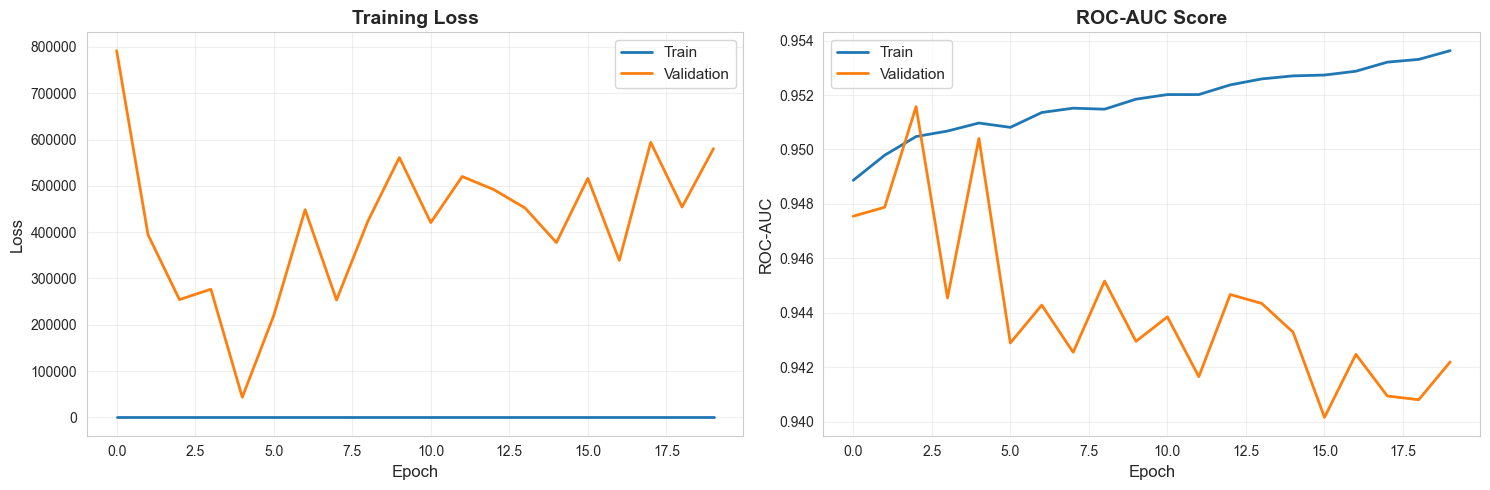

✅ Saved: reports/figs/mlp_training_history.png


In [18]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax = axes[0]
ax.plot(history['train_loss'], label='Train', linewidth=2)
ax.plot(history['val_loss'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# ROC-AUC
ax = axes[1]
ax.plot(history['train_auc'], label='Train', linewidth=2)
ax.plot(history['val_auc'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('ROC-AUC', fontsize=12)
ax.set_title('ROC-AUC Score', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figs/mlp_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print('✅ Saved: reports/figs/mlp_training_history.png')

## 5. Evaluation on Validation Set

In [19]:
print('='*70)
print('EVALUATION - VALIDATION SET')
print('='*70)

# Get predictions
mlp_probs_val = trainer.predict_proba(X_val)

# Evaluate
mlp_metrics = evaluate_binary_classifier(y_val, mlp_probs_val)

print(f"\nROC-AUC:      {mlp_metrics['roc_auc']:.4f}")
print(f"PR-AUC:       {mlp_metrics['pr_auc']:.4f}")
print(f"F1 Score:     {mlp_metrics.get('f1_score', mlp_metrics.get('f1', 0)):.4f}")
print(f"Brier Score:  {mlp_metrics['brier_score']:.4f}")
print('\n' + '='*70)

EVALUATION - VALIDATION SET
CLASSIFICATION METRICS
ROC-AUC:       0.9422
PR-AUC:        0.8975
F1 Score:      0.8191
Brier Score:   0.0719
Accuracy:      0.9051
Precision:     0.7350
Recall:        0.9250
Specificity:   0.8991

Confusion Matrix:
  TN:  319,173  |  FP:   35,832
  FN:    8,052  |  TP:   99,369

ROC-AUC:      0.9422
PR-AUC:       0.8975
F1 Score:     0.8191
Brier Score:  0.0719

CLASSIFICATION METRICS
ROC-AUC:       0.9422
PR-AUC:        0.8975
F1 Score:      0.8191
Brier Score:   0.0719
Accuracy:      0.9051
Precision:     0.7350
Recall:        0.9250
Specificity:   0.8991

Confusion Matrix:
  TN:  319,173  |  FP:   35,832
  FN:    8,052  |  TP:   99,369

ROC-AUC:      0.9422
PR-AUC:       0.8975
F1 Score:     0.8191
Brier Score:  0.0719



## 6. Profit-Based Threshold Optimization

PROFIT-BASED THRESHOLD OPTIMIZATION - MLP
THRESHOLD OPTIMIZATION FOR PROFIT MAXIMIZATION
Thresholds tested: 91
Range: 0.050 to 0.950

Optimal threshold: 0.520
Maximum profit:    $432,807,975.86
Approval rate:     71.26%
Default rate (approved): 2.53%
THRESHOLD OPTIMIZATION FOR PROFIT MAXIMIZATION
Thresholds tested: 91
Range: 0.050 to 0.950

Optimal threshold: 0.520
Maximum profit:    $432,807,975.86
Approval rate:     71.26%
Default rate (approved): 2.53%


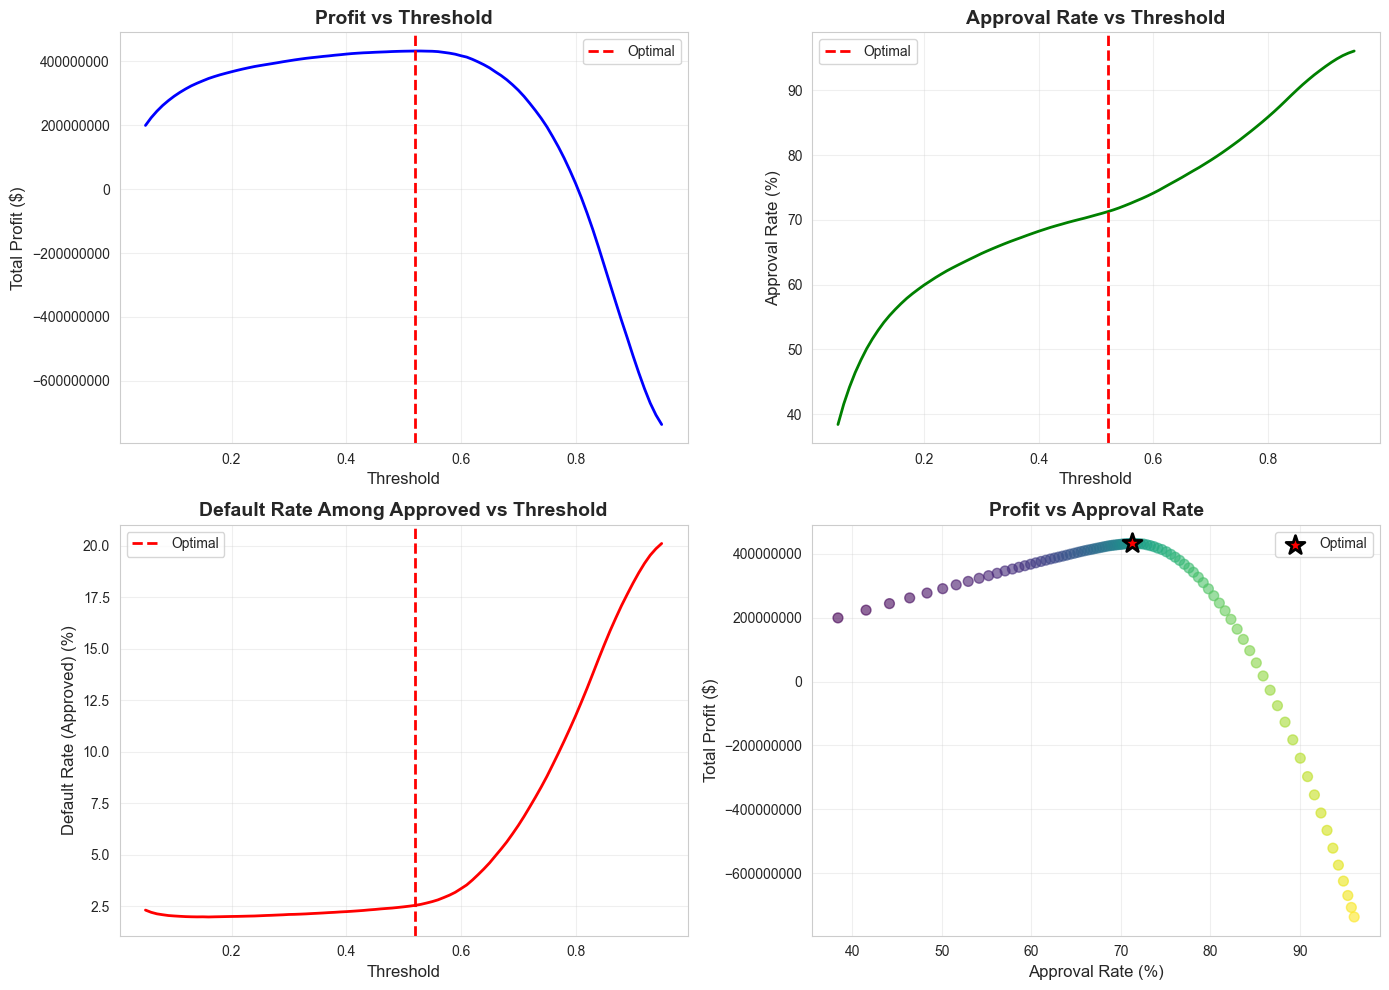


✅ Threshold optimization complete
✅ Saved: reports/figs/mlp_threshold_optimization.png


In [23]:
# Optimize threshold for MLP
if 'loan_amnt' in val_df_original.columns and 'int_rate' in val_df_original.columns:
    print('='*70)
    print('PROFIT-BASED THRESHOLD OPTIMIZATION - MLP')
    print('='*70)
    
    optimal_threshold, max_profit, results_df = optimize_threshold_for_profit(
        y_true=y_val,
        y_pred_proba=mlp_probs_val,
        loan_amnt=val_df_original['loan_amnt'].values,
        int_rate=val_df_original['int_rate'].values,
        verbose=True
    )
    
    # Plot
    plot_threshold_optimization(
        results_df=results_df,
        optimal_threshold=optimal_threshold
    )
    plt.savefig('../reports/figs/mlp_threshold_optimization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print('\n✅ Threshold optimization complete')
    print('✅ Saved: reports/figs/mlp_threshold_optimization.png')
else:
    print('⚠️  loan_amnt or int_rate not found - skipping profit optimization')

## 7. Test Set Evaluation

In [ ]:
print('='*70)
print('FINAL EVALUATION - TEST SET')
print('='*70)

# Get predictions
mlp_probs_test = trainer.predict_proba(X_test)

# Evaluate
test_metrics = evaluate_binary_classifier(y_test, mlp_probs_test)

print(f"\nROC-AUC:      {test_metrics['roc_auc']:.4f}")
print(f"PR-AUC:       {test_metrics['pr_auc']:.4f}")
print(f"F1 Score:     {test_metrics.get('f1_score', test_metrics.get('f1', 0)):.4f}")
print(f"Brier Score:  {test_metrics['brier_score']:.4f}")
print('\n' + '='*70)

FINAL EVALUATION - TEST SET
CLASSIFICATION METRICS
ROC-AUC:       0.8290
PR-AUC:        0.7994
F1 Score:      0.7860
Brier Score:   0.0613
Accuracy:      0.9338
Precision:     0.8007
Recall:        0.7718
Specificity:   0.9641

Confusion Matrix:
  TN:   45,739  |  FP:    1,705
  FN:    2,025  |  TP:    6,849

ROC-AUC:      0.8290
PR-AUC:       0.7994
F1 Score:     0.7860
Brier Score:  0.0613

CLASSIFICATION METRICS
ROC-AUC:       0.8290
PR-AUC:        0.7994
F1 Score:      0.7860
Brier Score:   0.0613
Accuracy:      0.9338
Precision:     0.8007
Recall:        0.7718
Specificity:   0.9641

Confusion Matrix:
  TN:   45,739  |  FP:    1,705
  FN:    2,025  |  TP:    6,849

ROC-AUC:      0.8290
PR-AUC:       0.7994
F1 Score:     0.7860
Brier Score:  0.0613



## 8. Save Model

In [ ]:
# Save trained model
model_path = Path('../models/saved/mlp_classifier.pt')
model_path.parent.mkdir(parents=True, exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'input_dim': input_dim,
    'hidden_dims': hidden_dims,
    'metrics': test_metrics,
    'history': history
}, model_path)

print(f'✅ Model saved: {model_path}')

✅ Model saved: ../models/saved/mlp_classifier.pt


## 9. Summary

In [ ]:
print('='*70)
print('PHASE 2.3 COMPLETE - MLP CLASSIFIER')
print('='*70)
print('\n✅ Model Architecture:')
print(f'   Input: {input_dim} features')
print(f'   Hidden: {hidden_dims}')
print(f'   Parameters: {sum(p.numel() for p in model.parameters()):,}')
print('\n✅ Training:')
print(f'   Epochs: {len(history["train_loss"])}')
print(f'   Best Val AUC: {max(history["val_auc"]):.4f}')
print('\n✅ Test Performance:')
print(f'   ROC-AUC: {test_metrics["roc_auc"]:.4f}')
print(f'   PR-AUC:  {test_metrics["pr_auc"]:.4f}')
print('\n✅ Artifacts Saved:')
print('   - Training history plot')
print('   - Threshold optimization plot')
print('   - Trained model checkpoint')
print('\n' + '='*70)
print('PHASE 2 COMPLETE! 🎉')
print('='*70)
print('\nNext: Phase 3 - Offline Reinforcement Learning')
print('='*70)